# Transformer Audio Inference

In [1]:
import os
from comet_ml import Experiment
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
import torch.nn.functional as F
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd

In [2]:
class TextTransform:
    """Maps characters to integers and vice versa"""
    def __init__(self):
        char_map_str = """
        ' 0
        <SPACE> 1
        a 2
        b 3
        c 4
        d 5
        e 6
        f 7
        g 8
        h 9
        i 10
        j 11
        k 12
        l 13
        m 14
        n 15
        o 16
        p 17
        q 18
        r 19
        s 20
        t 21
        u 22
        v 23
        w 24
        x 25
        y 26
        z 27
        """
        self.char_map = {}
        self.index_map = {}
        for line in char_map_str.strip().split('\n'):
            ch, index = line.split()
            self.char_map[ch] = int(index)
            self.index_map[int(index)] = ch
        self.index_map[1] = ' '

    def text_to_int(self, text):
        """ Use a character map and convert text to an integer sequence """
        int_sequence = []
        for c in text:
            if c == ' ':
                ch = self.char_map['<SPACE>']
            else:
                ch = self.char_map[c]
            int_sequence.append(ch)
        return int_sequence

    def int_to_text(self, labels):
        """ Use a character map and convert integer labels to an text sequence """
        string = []
        for i in labels:
            string.append(self.index_map[i])
        return ''.join(string).replace('<SPACE>', ' ')

In [3]:
train_audio_transforms = nn.Sequential(
    torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_mels=128),
    torchaudio.transforms.FrequencyMasking(freq_mask_param=30),
    torchaudio.transforms.TimeMasking(time_mask_param=100)
)

valid_audio_transforms = torchaudio.transforms.MelSpectrogram()

text_transform = TextTransform()

/usr/local/lib/python3.6/dist-packages/torchaudio/functional/functional.py:358: UserWarning:

At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.



In [4]:
def data_processing(data, data_type="train"):
    spectrograms = []
    labels = []
    input_lengths = []
    label_lengths = []
    for (waveform, _, utterance, _, _, _) in data:
        if data_type == 'train':
            spec = train_audio_transforms(waveform).squeeze(0).transpose(0, 1)
        else:
            spec = valid_audio_transforms(waveform).squeeze(0).transpose(0, 1)
        spectrograms.append(spec)
        label = torch.Tensor(text_transform.text_to_int(utterance.lower()))
        labels.append(label)
        input_lengths.append(spec.shape[0]//2)
        label_lengths.append(len(label))

    spectrograms = nn.utils.rnn.pad_sequence(spectrograms, batch_first=True).unsqueeze(1).transpose(2, 3)
    labels = nn.utils.rnn.pad_sequence(labels, batch_first=True)

    return spectrograms, labels, input_lengths, label_lengths

In [5]:
class CNNLayerNorm(nn.Module):
    """Layer normalization built for cnns input"""
    def __init__(self, n_feats):
        super(CNNLayerNorm, self).__init__()
        self.layer_norm = nn.LayerNorm(n_feats)

    def forward(self, x):
        # x (batch, channel, feature, time)
        x = x.transpose(2, 3).contiguous() # (batch, channel, time, feature)
        x = self.layer_norm(x)
        return x.transpose(2, 3).contiguous() # (batch, channel, feature, time) 


class ResidualCNN(nn.Module):
    """Residual CNN inspired by https://arxiv.org/pdf/1603.05027.pdf
        except with layer norm instead of batch norm
    """
    def __init__(self, in_channels, out_channels, kernel, stride, dropout, n_feats):
        super(ResidualCNN, self).__init__()

        self.cnn1 = nn.Conv2d(in_channels, out_channels, kernel, stride, padding=kernel//2)
        self.cnn2 = nn.Conv2d(out_channels, out_channels, kernel, stride, padding=kernel//2)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.layer_norm1 = CNNLayerNorm(n_feats)
        self.layer_norm2 = CNNLayerNorm(n_feats)

    def forward(self, x):
        residual = x  # (batch, channel, feature, time)
        x = self.layer_norm1(x)
        x = F.gelu(x)
        x = self.dropout1(x)
        x = self.cnn1(x)
        x = self.layer_norm2(x)
        x = F.gelu(x)
        x = self.dropout2(x)
        x = self.cnn2(x)
        x += residual
        return x # (batch, channel, feature, time)

class BidirectionalGRU(nn.Module):

    def __init__(self, rnn_dim, hidden_size, dropout, batch_first):
        super(BidirectionalGRU, self).__init__()

        self.BiGRU = nn.GRU(
            input_size=rnn_dim, hidden_size=hidden_size,
            num_layers=1, batch_first=batch_first, bidirectional=True)
        self.layer_norm = nn.LayerNorm(rnn_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.layer_norm(x)
        x = F.gelu(x)
        x, _ = self.BiGRU(x)
        x = self.dropout(x)
        return x


class SpeechRecognitionModel(nn.Module):
    """Speech Recognition Model Inspired by DeepSpeech 2"""

    def __init__(self, n_cnn_layers, n_rnn_layers, rnn_dim, n_class, n_feats, stride=2, dropout=0.1):
        super(SpeechRecognitionModel, self).__init__()
        n_feats = n_feats//2
        self.cnn = nn.Conv2d(1, 32, 3, stride=stride, padding=3//2)  # cnn for extracting heirachal features

        # n residual cnn layers with filter size of 32
        self.rescnn_layers = nn.Sequential(*[
            ResidualCNN(32, 32, kernel=3, stride=1, dropout=dropout, n_feats=n_feats) 
            for _ in range(n_cnn_layers)
        ])
        self.fully_connected = nn.Linear(n_feats*32, rnn_dim)
        self.birnn_layers = nn.Sequential(*[
            BidirectionalGRU(rnn_dim=rnn_dim if i==0 else rnn_dim*2,
                             hidden_size=rnn_dim, dropout=dropout, batch_first=i==0)
            for i in range(n_rnn_layers)
        ])
        self.classifier = nn.Sequential(
            nn.Linear(rnn_dim*2, rnn_dim),  # birnn returns rnn_dim*2
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(rnn_dim, n_class)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = self.rescnn_layers(x)
        sizes = x.size()
        x = x.view(sizes[0], sizes[1] * sizes[2], sizes[3])  # (batch, feature, time)
        x = x.transpose(1, 2) # (batch, time, feature)
        x = self.fully_connected(x)
        x = self.birnn_layers(x)
        x = self.classifier(x)
        return x

In [6]:
def avg_wer(wer_scores, combined_ref_len):
    return float(sum(wer_scores)) / float(combined_ref_len)


def _levenshtein_distance(ref, hyp):
    """Levenshtein distance is a string metric for measuring the difference
    between two sequences. Informally, the levenshtein disctance is defined as
    the minimum number of single-character edits (substitutions, insertions or
    deletions) required to change one word into the other. We can naturally
    extend the edits to word level when calculate levenshtein disctance for
    two sentences.
    """
    m = len(ref)
    n = len(hyp)

    # special case
    if ref == hyp:
        return 0
    if m == 0:
        return n
    if n == 0:
        return m

    if m < n:
        ref, hyp = hyp, ref
        m, n = n, m

    # use O(min(m, n)) space
    distance = np.zeros((2, n + 1), dtype=np.int32)

    # initialize distance matrix
    for j in range(0,n + 1):
        distance[0][j] = j

    # calculate levenshtein distance
    for i in range(1, m + 1):
        prev_row_idx = (i - 1) % 2
        cur_row_idx = i % 2
        distance[cur_row_idx][0] = i
        for j in range(1, n + 1):
            if ref[i - 1] == hyp[j - 1]:
                distance[cur_row_idx][j] = distance[prev_row_idx][j - 1]
            else:
                s_num = distance[prev_row_idx][j - 1] + 1
                i_num = distance[cur_row_idx][j - 1] + 1
                d_num = distance[prev_row_idx][j] + 1
                distance[cur_row_idx][j] = min(s_num, i_num, d_num)

    return distance[m % 2][n]


def word_errors(reference, hypothesis, ignore_case=False, delimiter=' '):
    """Compute the levenshtein distance between reference sequence and
    hypothesis sequence in word-level.
    :param reference: The reference sentence.
    :type reference: basestring
    :param hypothesis: The hypothesis sentence.
    :type hypothesis: basestring
    :param ignore_case: Whether case-sensitive or not.
    :type ignore_case: bool
    :param delimiter: Delimiter of input sentences.
    :type delimiter: char
    :return: Levenshtein distance and word number of reference sentence.
    :rtype: list
    """
    if ignore_case == True:
        reference = reference.lower()
        hypothesis = hypothesis.lower()

    ref_words = reference.split(delimiter)
    hyp_words = hypothesis.split(delimiter)

    edit_distance = _levenshtein_distance(ref_words, hyp_words)
    return float(edit_distance), len(ref_words)


def char_errors(reference, hypothesis, ignore_case=False, remove_space=False):
    """Compute the levenshtein distance between reference sequence and
    hypothesis sequence in char-level.
    :param reference: The reference sentence.
    :type reference: basestring
    :param hypothesis: The hypothesis sentence.
    :type hypothesis: basestring
    :param ignore_case: Whether case-sensitive or not.
    :type ignore_case: bool
    :param remove_space: Whether remove internal space characters
    :type remove_space: bool
    :return: Levenshtein distance and length of reference sentence.
    :rtype: list
    """
    if ignore_case == True:
        reference = reference.lower()
        hypothesis = hypothesis.lower()

    join_char = ' '
    if remove_space == True:
        join_char = ''

    reference = join_char.join(filter(None, reference.split(' ')))
    hypothesis = join_char.join(filter(None, hypothesis.split(' ')))

    edit_distance = _levenshtein_distance(reference, hypothesis)
    return float(edit_distance), len(reference)


def wer(reference, hypothesis, ignore_case=False, delimiter=' '):
    """Calculate word error rate (WER). WER compares reference text and
    hypothesis text in word-level. WER is defined as:
    .. math::
        WER = (Sw + Dw + Iw) / Nw
    where
    .. code-block:: text
        Sw is the number of words subsituted,
        Dw is the number of words deleted,
        Iw is the number of words inserted,
        Nw is the number of words in the reference
    We can use levenshtein distance to calculate WER. Please draw an attention
    that empty items will be removed when splitting sentences by delimiter.
    :param reference: The reference sentence.
    :type reference: basestring
    :param hypothesis: The hypothesis sentence.
    :type hypothesis: basestring
    :param ignore_case: Whether case-sensitive or not.
    :type ignore_case: bool
    :param delimiter: Delimiter of input sentences.
    :type delimiter: char
    :return: Word error rate.
    :rtype: float
    :raises ValueError: If word number of reference is zero.
    """
    edit_distance, ref_len = word_errors(reference, hypothesis, ignore_case,
                                         delimiter)

    if ref_len == 0:
        raise ValueError("Reference's word number should be greater than 0.")

    wer = float(edit_distance) / ref_len
    return wer


def cer(reference, hypothesis, ignore_case=False, remove_space=False):
    """Calculate charactor error rate (CER). CER compares reference text and
    hypothesis text in char-level. CER is defined as:
    .. math::
        CER = (Sc + Dc + Ic) / Nc
    where
    .. code-block:: text
        Sc is the number of characters substituted,
        Dc is the number of characters deleted,
        Ic is the number of characters inserted
        Nc is the number of characters in the reference
    We can use levenshtein distance to calculate CER. Chinese input should be
    encoded to unicode. Please draw an attention that the leading and tailing
    space characters will be truncated and multiple consecutive space
    characters in a sentence will be replaced by one space character.
    :param reference: The reference sentence.
    :type reference: basestring
    :param hypothesis: The hypothesis sentence.
    :type hypothesis: basestring
    :param ignore_case: Whether case-sensitive or not.
    :type ignore_case: bool
    :param remove_space: Whether remove internal space characters
    :type remove_space: bool
    :return: Character error rate.
    :rtype: float
    :raises ValueError: If the reference length is zero.
    """
    edit_distance, ref_len = char_errors(reference, hypothesis, ignore_case,
                                         remove_space)

    if ref_len == 0:
        raise ValueError("Length of reference should be greater than 0.")

    cer = float(edit_distance) / ref_len
    return cer

In [7]:
class IterMeter(object):
    """keeps track of total iterations"""
    def __init__(self):
        self.val = 0

    def step(self):
        self.val += 1

    def get(self):
        return self.val

def train(model, device, train_loader, criterion, optimizer, scheduler, epoch, iter_meter):
# def train(model, device, train_loader, criterion, optimizer, scheduler, epoch, iter_meter, experiment):
    model.train()
    data_len = len(train_loader.dataset)
#     with experiment.train():
    for batch_idx, _data in enumerate(train_loader):
        spectrograms, labels, input_lengths, label_lengths = _data 
        spectrograms, labels = spectrograms.to(device), labels.to(device)

        optimizer.zero_grad()

        output = model(spectrograms)  # (batch, time, n_class)
        output = F.log_softmax(output, dim=2)
        output = output.transpose(0, 1) # (time, batch, n_class)

        loss = criterion(output, labels, input_lengths, label_lengths)
        loss.backward()

#         experiment.log_metric('loss', loss.item(), step=iter_meter.get())
#         experiment.log_metric('learning_rate', scheduler.get_lr(), step=iter_meter.get())

        optimizer.step()
        scheduler.step()
        iter_meter.step()
        
#         torch.save(model.state_dict(), f'../../weights/transformer_with_torchtext/transformer_{epoch}.pth.tar')
        torch.save(model.state_dict(), f'../../weights/transformer_speech_recog/speech_recog_{epoch}.pth.tar')

        if batch_idx % 100 == 0 or batch_idx == data_len:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(spectrograms), data_len,
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader, criterion, epoch, iter_meter):
# def test(model, device, test_loader, criterion, epoch, iter_meter, experiment):
    print('\nevaluating...')
    model.eval()
    test_loss = 0
    test_cer, test_wer = [], []
#     with experiment.test():
    with torch.no_grad():
        for i, _data in enumerate(test_loader):
            spectrograms, labels, input_lengths, label_lengths = _data 
            spectrograms, labels = spectrograms.to(device), labels.to(device)

            output = model(spectrograms)  # (batch, time, n_class)
            output = F.log_softmax(output, dim=2)
            output = output.transpose(0, 1) # (time, batch, n_class)

            loss = criterion(output, labels, input_lengths, label_lengths)
            test_loss += loss.item() / len(test_loader)

            decoded_preds, decoded_targets = GreedyDecoder(output.transpose(0, 1), labels, label_lengths)
            for j in range(len(decoded_preds)):
                test_cer.append(cer(decoded_targets[j], decoded_preds[j]))
                test_wer.append(wer(decoded_targets[j], decoded_preds[j]))


    avg_cer = sum(test_cer)/len(test_cer)
    avg_wer = sum(test_wer)/len(test_wer)
#     experiment.log_metric('test_loss', test_loss, step=iter_meter.get())
#     experiment.log_metric('cer', avg_cer, step=iter_meter.get())
#     experiment.log_metric('wer', avg_wer, step=iter_meter.get())

    print('Test set: Average loss: {:.4f}, Average CER: {:4f} Average WER: {:.4f}\n'.format(test_loss, avg_cer, avg_wer))
#     print(decoded_preds, decoded_targets)
    return decoded_preds, decoded_targets

In [8]:
learning_rate = 5e-4
batch_size    = 20
epochs        = 10

# experiment=Experiment(api_key='dummy_key', disabled=True)

hparams = {
        "n_cnn_layers": 3,
        "n_rnn_layers": 5,
        "rnn_dim": 512,
        "n_class": 29,
        "n_feats": 128,
        "stride":2,
        "dropout": 0.1,
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "epochs": epochs
    }

# experiment.log_parameters(hparams)

use_cuda = torch.cuda.is_available()
device = "cuda:1"

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

model = SpeechRecognitionModel(
    hparams['n_cnn_layers'], hparams['n_rnn_layers'], hparams['rnn_dim'],
    hparams['n_class'], hparams['n_feats'], hparams['stride'], hparams['dropout']
    ).to(device)

# print(model)
print('Num Model Parameters', sum([param.nelement() for param in model.parameters()]))

criterion = nn.CTCLoss(blank=28).to(device)

Num Model Parameters 23705373


In [9]:
def GreedyDecoder(output, labels, label_lengths, blank_label=28, collapse_repeated=True):
    arg_maxes = torch.argmax(output, dim=2)
    decodes = []
    targets = []
    for i, args in enumerate(arg_maxes):
        decode = []
        targets.append(text_transform.int_to_text(labels[i][:label_lengths[i]].tolist()))
        for j, index in enumerate(args):
            if index != blank_label:
                if collapse_repeated and j != 0 and index == args[j -1]:
                    continue
                decode.append(index.item())
        decodes.append(text_transform.int_to_text(decode))
    return decodes, targets

torch.Size([2, 1191141])
torch.Size([1, 440000])
44100


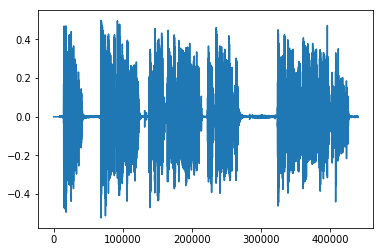

In [10]:
waveform_org, sample_rate = torchaudio.load('tom_hiddleston_explains_pi.mp3')
print(waveform_org.shape) # my audio has 2 channels i will make it 1

waveform = waveform_org[0][:440000].reshape(1,-1)
print(waveform.shape)
print(sample_rate)

plt.plot(waveform.t().numpy());

ipd.Audio(waveform.numpy(), rate=sample_rate)

In [11]:
utterance = 'PI IS THE CIRCUMFERENCE DIVIDED BY THE DIAMETER OF ANY CIRCLE ITS IMPOSSIBLE TO KNOW THE EXACT VALUE'

my_audio = (waveform, sample_rate, utterance, 103, 1240, 0) # make my input has the same format as the input data
print(my_audio)

my_audio_list = [my_audio]

my_processed_audio = data_processing(my_audio_list, data_type="valid")

my_loader = [my_processed_audio]

(tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -4.2450e-04,
         -1.5330e-04,  9.5367e-07]]), 44100, 'PI IS THE CIRCUMFERENCE DIVIDED BY THE DIAMETER OF ANY CIRCLE ITS IMPOSSIBLE TO KNOW THE EXACT VALUE', 103, 1240, 0)


In [12]:
model.load_state_dict(torch.load('../../weights/transformer_speech_recog/SpeechRecog_9.pth'))

<All keys matched successfully>

In [13]:
epochs = 1
iter_meter = IterMeter()

for epoch in range(1, epochs + 1):
    decoded_preds, decoded_targets = test(model, device, my_loader, criterion, epoch, iter_meter)
    
print("DECODED PREDICTIONS : ", decoded_preds)
print("TARGETS : ", decoded_targets)


evaluating...
Test set: Average loss: 3.8739, Average CER: 0.760000 Average WER: 1.0000

DECODED PREDICTIONS :  ['boaah ao su bo too ao r apa i  wt o oo  h  h']
TARGETS :  ['pi is the circumference divided by the diameter of any circle its impossible to know the exact value']
